<a href="https://colab.research.google.com/github/MosheWasserb/PyTorchNotbooks/blob/master/Glove_CNN_MultiClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Based Emotion Recognition with PyTorch

![alt txt](https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks/blob/master/img/emotion_classifier.png?raw=true)

In this notebook we are going to learn how to train deep neural networks, such as recurrent neural networks (RNNs), for addressing a natural language task known as **emotion recognition**. We will cover everything you need to know to get started with NLP using deep learning frameworks such as TensorFlow. We will cover the common best practices, functionalities, and steps you need to understand the basics of TensorFlow APIs to build powerful predictive models via the computation graph. In the process of building our models, we will compare PyTorch and TensorFlow to let the learner appreciate the strenghts of each tool.

by [Elvis Saravia](https://twitter.com/omarsar0)

---

## Outline
1. Deep Learning Frameworks
     - 1.1 Eager execution
     - 1.2 Computation graph
2. Tensors
    - 2.1 Basic math with tensors
    - 2.2 Transforming tensors
3. Data
    - 3.1 Preprocessing data
        - Tokenization and Sampling
        - Constructing Vocabulary and Index-Word Mapping
    - 3.2 Converting data into tensors
    - 3.3 Padding data
    - 3.4 Binarization
    - 3.5 Split data
    - 3.6 Data Loader
4. Model
    - 4.1 Pretesting Model
    - 4.2 Testing models with eager execution
5. Training
6. Evaluation on Testing Dataset
    - 6.1 Confusion matrix
- Final Words
- References
- *Storing models and setting checkpoints (Exercise)*
- *Restoring models (Exercise)*

---

## 1. Deep Learning Frameworks
There are many deep learning frameworks such as Chainer, DyNet, MXNet, PyTorch, TensorFlow, and Keras. Each framework has their own strenghts which a researcher or a developer may want to consider before choosing the right framework. In my opinion, PyTorch is great for researchers and offers eager execution by default, but its high-level APIs require some understanding of deep learning concepts such as **affine layers** and **automatic differentiation**. On the other hand, TensorFlow was originally built as a low-level API that provides a robust list of functionalities to build deep learning models from the ground up. More recently, TensorFlow also offers **eager execution** and is equipped with a high-level API known as Keras.

![alt txt](https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks/blob/master/img/dl_frameworks.png?raw=true)

### 1.1 Eager Execution
Eager execution allows us to operate on the computation graph dynamically, also known as **imperative programming**. TensorFlow requires that you manually set this mode, while PyTorch comes with this mode by default. Below we import the necessary libraries to use PyTorch.

In [0]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.1-cp36-cp36m-linux_x86_64.whl 

In [0]:
import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

### 1.2 Computation Graph
A simplified definition of a neural network is a string of functions that are **differentiable** and that we can combine together to get more complicated functions. An intuitive way to express this process is through computation graphs. 

![alt txt](http://colah.github.io/posts/2015-08-Backprop/img/tree-eval-derivs.png)

Image credit: [Chris Olah](http://colah.github.io/posts/2015-08-Backprop/)

## 2. Tensors
Tensors are the fundamental data structure used to store data that will be fed as input to a computation graph for processing and applying tranformations. Let's create two tensors and multiply them, and then output the result. The figure below shows a 4-D Tensor.

![alt txt](https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks/blob/master/img/tensor.png?raw=true)

In [0]:
c = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
d = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
e = torch.matmul(c, d)
print(e)
print(c.size())

tensor([[1., 3.],
        [3., 7.]])
torch.Size([2, 2])


### 2.1 Math with Tensors
PyTorch and other deep learning libraries like TensorFlow allow you to do **automatic differentation**. Let's try to compute the derivative of a function -- in this case that function is stored in the variable `z`. In PyTorch, the option `requires_grad=True` tracks all operations applied to the input tensor. 

In [0]:
### Automatic differentiation with PyTorch
x = torch.ones(2, 2, requires_grad=True)

# an operation of tensor
y = x + 2 # y inherits grad_fn

# apply operations on y
z = y * y * 3
out = z.mean()

print(out)

out.backward()

print(x.grad) # d(out)/dx

tensor(27., grad_fn=<MeanBackward1>)
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


You can verfiy the output with the equations in the figure below:

![alt txt](https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks/blob/master/img/autograd.jpg?raw=true)

### 2.2 Transforming Tensors
We can also apply some transformation to a tensor such as adding a dimension or transposing it. Let's try both adding a dimension and transposing a matrix below.

In [0]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
print("X shape: ", x.size())

# add dimension
print(x.unsqueeze(1).size()) 

# transpose 
torch.transpose(x, 0,1)

X shape:  torch.Size([2, 3])
torch.Size([2, 1, 3])


tensor([[1, 4],
        [2, 5],
        [3, 6]])

## 3. Emotion Dataset
In this notebook we are working on an emotion classification task. The dataset contains tweets labeled into 6 categories.

In [0]:
import re
import numpy as np
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [0]:
### Helper functions
import pickle

def convert_to_pickle(item, directory):
    pickle.dump(item, open(directory,"wb"))


def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

In [6]:
### read data from your Google Drive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


We had already processed the data for you. You can find the pickle file [here](https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks/blob/master/data/merged_training.pkl).

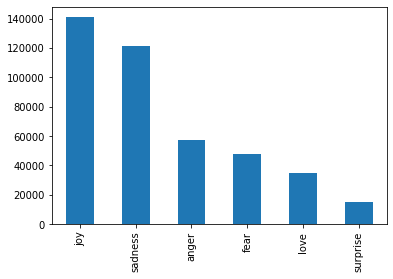

In [7]:
# load data
data = pd.read_csv(r"/gdrive/My Drive/Colab Notebooks/DAIR/EmotionDataSet/multiclass6ed.csv")
data.emotions.value_counts().plot.bar()


In [8]:
data.head(10)

,text,emotions
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love
5,i find myself frustrated with christians becau...,love
6,i am one of those people who feels like going ...,joy
7,i feel especially pleased about this as this h...,joy
8,i was struggling with these awful feelings and...,joy
9,i feel so enraged but helpless at the same time,anger


### 3.1 Preprocessing Data
In the next steps we are going to create tokenize the text, create index mapping for words, and also construct a vocabulary. 

#### Tokenization and Sampling

In [0]:
# retain only text that contain less that 70 tokens to avoid too much padding
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 70].copy()

# sampling
data = data.sample(n=8000, random_state = 42);

In [0]:
    def generate_bigrams(x):
      n_grams = set(zip(*[x[i:] for i in range(2)]))
      for n_gram in n_grams:
          x.append(' '.join(n_gram))
      return x

#### Constructing Vocabulary and Index-Word Mapping

In [0]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            # self.vocab.update(generate_bigrams(s.split(' ')))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  

In [98]:
# construct vocab and indexing
inputs = ConstructVocab(data["text"].values.tolist())

# examples of what is in the vocab
inputs.vocab[0:10]

['a',
 'aajao',
 'aakhri',
 'aarons',
 'aba',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abbey']

In [75]:
len(inputs.vocab)

73886

### 3.2 Converting Data into Tensors 
For convenience we would like to convert the data into tensors. 

In [0]:
# vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [0]:
# examples of what is in the input tensors
input_tensor[0:2]

### 3.3 Padding data
In order to train our recurrent neural network later on in the notebook, it is required padding to generate inputs of same length.

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [101]:
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

69


In [0]:
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [0]:
# inplace padding
input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]

In [23]:
input_tensor[0:2]

[array([ 4507,  2716,  5160,  4532,  4920,  5055,  6080,  5969, 10332,
         4507,  7447,  9446,   413,  9446,  5964,  1263,  4507,  1313,
          685,  3720,  4911,  3409,     1,  5430,  5327,  9383,  4593,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]),
 array([ 4552,  4407,  9427,  5380,  9446,  6209,  2754,   923,  9446,
         9509,  8570,  9392,  4507, 10456,  3025,  9956,  3409,   553,
         2487,   553,  4507,  2517,  9398,  5236,  9509,  4507,  9755,
         4605,     1,  2754,  4507, 10225,  2487,   829,     1,  4448,
         4449,  6205,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    

In [0]:
# Build pre-trained embeddings 
emb_dim = 100
matrix_len = len(inputs.vocab)
weights_matrix = np.zeros((matrix_len, emb_dim))
words_found = 0

for i, word in enumerate(inputs.vocab):
    try: 
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))

pretrained_embeddings = weights_matrix

### 3.4 Binarization
We would like to binarize our target so that we can obtain one-hot encodings as target values. These are easier and more efficient to work with and will be useful when training the models.

In [0]:
### convert targets to one-hot encoding vectors
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)
# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [41]:
target_tensor[0:2] 

array([[0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

In [22]:
data[0:2]

,text,emotions,token_size
262883,i told my mom the other day i feel like i m al...,sadness,23
81642,i think its the strong feelings that i have fo...,sadness,19


In [0]:
get_emotion = lambda t: np.argmax(t)

In [24]:
get_emotion(target_tensor[0])

4

In [0]:
emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

In [0]:
emotion_dict[get_emotion(target_tensor[0])]

'joy'

### 3.5 Split data
We would like to split our data into a train and validation set. In addition, we also want a holdout dataset (test set) for evaluating the models.

In [105]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

input_tensor_test = input_tensor_val
target_tensor_test = target_tensor_val

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
#input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(6400, 6400, 1600, 1600, 1600, 1600)

### 3.6 Data Loader
We can also laod the data into a data loader, which makes it easy to **manipulate the data**, **create batches**, and apply further **transformations**. In PyTorch we can use the `DataLoader` function.

In [0]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = num_emotions

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
# convert the data to tensors and pass to the Dataloader 
# to create an batch iterator

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

In [0]:
train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)

train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [47]:
val_dataset.batch_size

64

## 4. Model
After the data has been preprocessed, transformed and prepared it is now time to construct the model or the so-called computation graph that will be used to train our classification models. We are going to use a gated recurrent neural network (GRU), which is considered a more efficient version of a basic RNN. The figure below shows a high-level overview of the model details. 

![alt txt](https://github.com/omarsar/nlp_pytorch_tensorflow_notebooks/blob/master/img/gru-model.png?raw=true)

### 4.1 Constructing the Model
Below we construct our model:

In [0]:
# Build pre-trained embeddings 

pretrained_embeddings =

In [2]:
class EmoGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
    
    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self, x, lens, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.gru(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :] 
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden  

NameError: ignored

In [1]:
model=EmoGRU()
model.embedding.weight.data.copy_(pretrained_embeddings)
# Zero the initial weights of our unknown and padding tokens.
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

NameError: ignored

### 4.2 Pretesting model
Since eager execution is enabled we can print the output of the model by passing a sample of the dataset and making sure that the dimensions of the outputs are the expected ones.

In [0]:
### sort batch function to be able to use with pad_packed_sequence
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0,1), y, lengths # transpose (batch x seq) to (seq x batch)

In [112]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

# obtain one sample from the data iterator
it = iter(train_dataset)
x, y, x_len = next(it)

# sort the batch first to be able to use with pac_pack sequence
xs, ys, lens = sort_batch(x, y, x_len)

print("Input size: ", xs.size())

output, _ = model(xs.to(device), lens, device)
print(output.size())

Input size:  torch.Size([69, 64])
torch.Size([64, 6])


## 5. Training the Model
Now that we have tested the model, it is time to train it. We will define out optimization algorithm, learnin rate, and other necessary information to train the model.

In [0]:
### Enabling cuda
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

### loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters())

def loss_function(y, prediction):
    """ CrossEntropyLoss expects outputs and class indices as target """
    # convert from one-hot encoding to class indices
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target) 
    return loss   #TODO: refer the parameter of these functions as the same
    
def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy

In [114]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    ### Initialize hidden state
    # TODO: do initialization here.
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0
    
    ### Training
    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        predictions, _ = model(inp.permute(1 ,0).to(device), lens, device) # TODO:don't need _   
              
        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))        
        total_loss += batch_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Val. Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.cpu().detach().numpy()))
            
    ### Validating
    for (batch, (inp, targ, lens)) in enumerate(val_dataset):        
        predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
        batch_accuracy = accuracy(targ.to(device), predictions)
        val_accuracy += batch_accuracy
    
    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1, 
                                                             total_loss / TRAIN_N_BATCH, 
                                                             train_accuracy / TRAIN_N_BATCH,
                                                             val_accuracy / VAL_N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val. Loss 0.2985
Epoch 1 Loss 0.2811 -- Train Acc. 31.2031 -- Val Acc. 29.7500
Time taken for 1 epoch 2.7862167358398438 sec

Epoch 2 Batch 0 Val. Loss 0.3062
Epoch 2 Loss 0.2614 -- Train Acc. 37.7344 -- Val Acc. 45.9375
Time taken for 1 epoch 2.756910800933838 sec

Epoch 3 Batch 0 Val. Loss 0.2271
Epoch 3 Loss 0.1571 -- Train Acc. 67.9062 -- Val Acc. 78.4375
Time taken for 1 epoch 2.777299165725708 sec

Epoch 4 Batch 0 Val. Loss 0.0672
Epoch 4 Loss 0.0565 -- Train Acc. 89.3125 -- Val Acc. 84.0625
Time taken for 1 epoch 2.773185968399048 sec

Epoch 5 Batch 0 Val. Loss 0.0282
Epoch 5 Loss 0.0233 -- Train Acc. 95.0156 -- Val Acc. 86.6250
Time taken for 1 epoch 2.7717573642730713 sec

Epoch 6 Batch 0 Val. Loss 0.0124
Epoch 6 Loss 0.0107 -- Train Acc. 97.8594 -- Val Acc. 84.8125
Time taken for 1 epoch 2.783438205718994 sec

Epoch 7 Batch 0 Val. Loss 0.0042
Epoch 7 Loss 0.0091 -- Train Acc. 97.9844 -- Val Acc. 86.3125
Time taken for 1 epoch 2.7727713584899902 sec

Epoch 8 Ba

In [93]:
model.parameters

<bound method Module.parameters of EmoGRU(
  (embedding): Embedding(73887, 256)
  (dropout): Dropout(p=0.5, inplace=False)
  (gru): GRU(256, 1024)
  (fc): Linear(in_features=1024, out_features=6, bias=True)
)>

## 6. Evaluation on the Testing Data
Now we will evaluate the model with the holdout dataset.

In [115]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

device = "cuda" # we don't need GPU to do testing
model.to("cuda")

for (batch, (inp, targ, lens)) in enumerate(test_dataset):          
    predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
    batch_accuracy = accuracy(targ.to(device), predictions)
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy.cpu().detach().numpy() / TEST_N_BATCH)

Test Accuracy:  85.875


### 6.1 Confusion Matrix
The test accuracy alone is not an interesting performance metric in this case. Let's plot a confusion matrix to get a drilled down view of how the model is performing with regards to each emotion.

In [0]:
### Class to Properly Evaluate our Models
class Evaluate():

    def va_dist(cls, prediction, target, va_df, binarizer, name='', silent=False):
        """ Computes distance between actual and prediction through cosine distance """
        va_matrix = va_df.loc[binarizer.classes_][['valence','arousal']].values
        y_va = target.dot(va_matrix)
        F_va = prediction.dot(va_matrix)

        # dist is a one row vector with size of the test data passed(emotion)
        dist = metrics.pairwise.paired_cosine_distances(y_va, F_va)
        res = stats.describe(dist)

        # print by default (if silent=False)
        if not silent:
            print('%s\tmean: %f\tvariance: %f' % (name, res.mean, res.variance))

        return {
            'distances': dist,
            'dist_stat': res
        }

    def evaluate_class(cls, predictions, target, target2=None, silent=False):
        """ Compute only the predicted class """
        p_2_annotation = dict()

        precision_recall_fscore_support = [
            (pair[0], pair[1].mean()) for pair in zip(
                ['precision', 'recall', 'f1', 'support'],
                metrics.precision_recall_fscore_support(target, predictions)
            )
        ]

        metrics.precision_recall_fscore_support(target, predictions)

        # confusion matrix
        le = LabelEncoder()
        target_le = le.fit_transform(target)
        predictions_le = le.transform(predictions)
        cm = metrics.confusion_matrix(target_le, predictions_le)

        # prediction if two annotations are given on test data
        if target2:
            p_2_annotation = pd.DataFrame(
                [(pred, pred in set([t1,t2])) for pred, t1, t2 in zip(predictions, target, target2)],
                columns=['emo','success']
            ).groupby('emo').apply(lambda emo: emo.success.sum()/ len(emo.success)).to_dict()

        if not silent:
            print("Default Classification report")
            print(metrics.classification_report(target, predictions))

            # print if target2 was provided
            if len(p_2_annotation) > 0:
                print('\nPrecision on 2 annotations:')
                for emo in p_2_annotation:
                    print("%s: %.2f" % (emo, p_2_annotation[emo]))

            # print accuracies, precision, recall, and f1
            print('\nAccuracy:')
            print(metrics.accuracy_score(target, predictions))
            print("Correct Predictions: ", metrics.accuracy_score(target, predictions,normalize=False))
            for to_print in precision_recall_fscore_support[:3]:
                print( "%s: %.2f" % to_print )

            # normalizing the values of the consfusion matrix
            print('\nconfusion matrix\n %s' % cm)
            print('(row=expected, col=predicted)')
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cls.plot_confusion_matrix(cm_normalized, le.classes_, 'Confusion matrix Normalized')

        return {
            'precision_recall_fscore_support': precision_recall_fscore_support,
            'accuracy': metrics.accuracy_score(target, predictions),
            'p_2_annotation': p_2_annotation,
            'confusion_matrix': cm
        }

    def predict_class(cls, X_train, y_train, X_test, y_test,
                      pipeline, silent=False, target2=None):
        """ Predicted class,then run some performance evaluation """
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict(X_test)
        print("predictions computed....")
        return cls.evaluate_class(predictions, y_test, target2, silent)

    def evaluate_prob(cls, prediction, target_rank, target_class, binarizer, va_df, silent=False, target2=None):
        """ Evaluate through probability """
        # Run normal class evaluator
        predict_class = binarizer.classes_[prediction.argmax(axis=1)]
        class_eval = cls.evaluate_class(predict_class, target_class, target2, silent)

        if not silent:
            print('\n - First Emotion Classification Metrics -')
            print('\n - Multiple Emotion rank Metrics -')
            print('VA Cosine Distance')

        classes_dist = [
            (
                emo,
                cls.va_dist(
                    prediction[np.array(target_class) == emo],
                    target_rank[np.array(target_class) == emo],
                    va_df,
                    binarizer,
                    emo,
                    silent)
                ) for emo in binarizer.classes_
        ]
        avg_dist = cls.va_dist(prediction, target_rank, va_df, binarizer, 'avg', silent)

        coverage_error = metrics.coverage_error(target_rank, prediction)
        average_precision_score = metrics.average_precision_score(target_rank, prediction)
        label_ranking_average_precision_score = metrics.label_ranking_average_precision_score(target_rank, prediction)
        label_ranking_loss = metrics.label_ranking_loss(target_rank, prediction)

        # recall at 2
        # obtain top two predictions
        top2_pred = [set([binarizer.classes_[i[0]], binarizer.classes_[i[1]]]) for i in (prediction.argsort(axis=1).T[-2:].T)]
        recall_at_2 = pd.DataFrame(
            [
            t in p for t, p in zip(target_class, top2_pred)
            ], index=target_class, columns=['recall@2']).groupby(level=0).apply(lambda emo: emo.sum()/len(emo))

        # combine target into sets
        if target2:
            union_target = [set(t) for t in zip(target_class, target2)]
        else:
            union_target = [set(t) for t in zip(target_class)]

        # precision at k
        top_k_pred = [
            [set([binarizer.classes_[i] for i in i_list]) for i_list in (prediction.argsort(axis=1).T[-i:].T)]
            for i in range(2, len(binarizer.classes_)+1)]
        precision_at_k = [
            ('p@' + str(k+2), np.array([len(t & p)/(k+2) for t, p in zip(union_target, top_k_pred[k])]).mean())
            for k in range(len(top_k_pred))]

        # do this if silent= False
        if not silent:
            print('\n')
            print(recall_at_2)
            print('\n')
            print('p@k')
            for pk in precision_at_k:
                print(pk[0] + ':\t' + str(pk[1]))
            print('\ncoverage_error: %f' % coverage_error)
            print('average_precision_score: %f' % average_precision_score)
            print('label_ranking_average_precision_score: %f' % label_ranking_average_precision_score)
            print('label_ranking_loss: %f' % label_ranking_loss)

        return {
            'class_eval': class_eval,
            'recall_at_2': recall_at_2.to_dict(),
            'precision_at_2': precision_at_k,
            'classes_dist': classes_dist,
            'avg_dist': avg_dist,
            'coverage_error': coverage_error,
            'average_precision_score': average_precision_score,
            'label_ranking_average_precision_score': label_ranking_average_precision_score,
            'label_ranking_loss': label_ranking_loss
        }


    def predict_prob(cls, X_train, y_train, X_test, y_test, label_test, pipeline, binarizer, va_df, silent=False, target2=None):
        """ Output predcations based on training and labels """
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict_proba(X_test)
        pred_to_mlb = [np.where(pipeline.classes_ == emo)[0][0] for emo in binarizer.classes_.tolist()]
        return cls.evaluate_prob(predictions[:,pred_to_mlb], y_test, label_test, binarizer, va_df, silent, target2)


    def plot_confusion_matrix(cls, cm, my_tags, title='Confusion matrix', cmap=plt.cm.Blues):
        """ Plotting the confusion_matrix"""
        plt.rc('figure', figsize=(4, 4), dpi=100)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(my_tags))
        target_names = my_tags
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
        # add normalized values inside the Confusion matrix
        fmt = '.2f'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

Default Classification report
              precision    recall  f1-score   support

       anger       0.85      0.82      0.83       228
        fear       0.88      0.79      0.83       165
         joy       0.89      0.89      0.89       555
        love       0.68      0.78      0.73       139
     sadness       0.90      0.90      0.90       461
    surprise       0.70      0.77      0.73        52

    accuracy                           0.86      1600
   macro avg       0.82      0.82      0.82      1600
weighted avg       0.86      0.86      0.86      1600


Accuracy:
0.85875
Correct Predictions:  1374
precision: 0.82
recall: 0.82
f1: 0.82

confusion matrix
 [[187   7  15   1  18   0]
 [  8 131   3   2  10  11]
 [  8   3 492  40   8   4]
 [  3   0  18 108   9   1]
 [ 14   3  20   7 416   1]
 [  0   5   5   0   2  40]]
(row=expected, col=predicted)


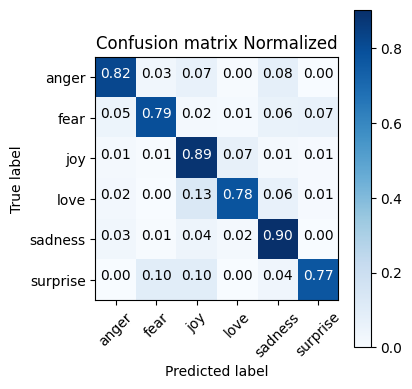

In [117]:
evaluator = Evaluate()

final_predictions = []

for p in all_predictions:
    for sub_p in p:
        final_predictions.append(sub_p.cpu().detach().numpy())
        
predictions = [np.argmax(p).item() for p in final_predictions]
targets = [np.argmax(t).item() for t in y_raw]
correct_predictions = float(np.sum(predictions == targets))

# predictions
predictions_human_readable = ((x_raw, predictions))
# actual targets
target_human_readable = ((x_raw,  targets))

emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

# convert results into dataframe
model_test_result = pd.DataFrame(predictions_human_readable[1],columns=["emotion"])
test = pd.DataFrame(target_human_readable[1], columns=["emotion"])

model_test_result.emotion = model_test_result.emotion.map(lambda x: emotion_dict[int(float(x))])
test.emotion = test.emotion.map(lambda x: emotion_dict[int(x)])

evaluator.evaluate_class(model_test_result.emotion, test.emotion );

## Final Words
You have learned how to perform neural-based emotion recognition using RNNs. There are many things you can do after you have completed this tutorial. You can attempt the exercises outlined in the "Outline" section of this notebook. You can also try other types of neural architectures such as LSTMs, Bi-LSTMS, attentions models, and CNNs. In addition, you can also store the models and conduct transfer learning to other emotion-related tasks. 

---

## References
- [Deep Learning for NLP](https://docs.google.com/presentation/d/1cf2H1qMvP1rdKUF5000ifOIRv1_b0bvj0ZTVL7-RaVE/edit?usp=sharing)
- [PyTorch Autograd Tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)
- [A Simple Neural Network from Scratch with PyTorch and Google Colab](https://medium.com/dair-ai/a-simple-neural-network-from-scratch-with-pytorch-and-google-colab-c7f3830618e0)
- [Building RNNs is Fun with PyTorch and Google Colab](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79?source=collection_home---4------2---------------------)
- [Deep Learning for NLP: An Overview of Recent Trends](https://medium.com/dair-ai/deep-learning-for-nlp-an-overview-of-recent-trends-d0d8f40a776d)